In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

# Reading Dataset - animelist.csv

In [2]:
import os 

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

# Data Processing

In [7]:
n_ratings = rating_df["user_id"].value_counts()

In [8]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [9]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [10]:
len(rating_df)

3246641

In [11]:
min_rating = min(rating_df["rating"])

In [12]:
max_rating = max(rating_df["rating"])

In [13]:
max_rating

10

In [14]:
avg_rating = np.mean(rating_df["rating"])

In [15]:
avg_rating

4.122732695114736

In [16]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [17]:
avg_rating = np.mean(rating_df["rating"])

In [18]:
avg_rating

0.4122732695114729

In [19]:
min_rating = min(rating_df["rating"])

In [20]:
min_rating

0.0

In [21]:
max_rating = max(rating_df["rating"])

In [22]:
max_rating

1.0

In [23]:
rating_df.duplicated().sum()

0

In [24]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [25]:
user_ids = rating_df["user_id"].unique().tolist()
 

In [26]:
user2user_encoded = {x : i for i, x in enumerate(user_ids)}

In [27]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [28]:
user2user_decoded = {i : x for i, x in enumerate(user_ids)}

In [29]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [30]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [31]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [32]:
n_users = len(user2user_encoded)

In [33]:
n_users

4203

In [34]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [35]:
n_anime = len(anime2anime_decoded)

In [36]:
n_anime

17149

In [37]:
rating_df =rating_df.sample(frac=1, random_state=43).reset_index(drop = True)

In [38]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [39]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [40]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [41]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [42]:
len(X_train)

3245641

In [43]:
len(X_test)

1000

In [44]:
type(X_train)

numpy.ndarray

In [45]:
X_train_array = [X_train[: , 0], X_train[:, 1]]
X_test_array = [X_test[: , 0], X_test[:, 1]]

In [46]:
type(X_train_array)

list

In [47]:
type(X_test_array)

list

#### Model Architecture

In [48]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim = n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape = [1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name = "dot_product", normalize=True, axes = 2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs = x)
    model.compile(loss="binary_crossentropy", metrics = ["mae","mse"], optimizer= 'Adam')

    return model

In [49]:
model = RecommenderNet()

In [50]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [51]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr- start_lr)/ramup_epochs*epoch + start_lr
    
    elif epoch<ramup_epochs +sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs) + min_lr

In [52]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch) , verbose = 0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor="val_loss", mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor="val_loss", mode="min",restore_best_weights=True)

In [53]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [54]:
history = model.fit(
    x=X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs=20,
    verbose = 1,
    validation_data = (X_test_array,y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.7992 - mae: 0.3818 - mse: 0.1968 - val_loss: 0.7282 - val_mae: 0.3667 - val_mse: 0.1719 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.7955 - mae: 0.3805 - mse: 0.1954 - val_loss: 0.7945 - val_mae: 0.3813 - val_mse: 0.1964 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.7899 - mae: 0.3783 - mse: 0.1932 - val_loss: 0.8010 - val_mae: 0.3826 - val_mse: 0.1985 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.7816 - mae: 0.3753 - mse: 0.1900 - val_loss: 0.7984 - val_mae: 0.3821 - val_mse: 0.1976 - learning_rate: 3.4000e-05


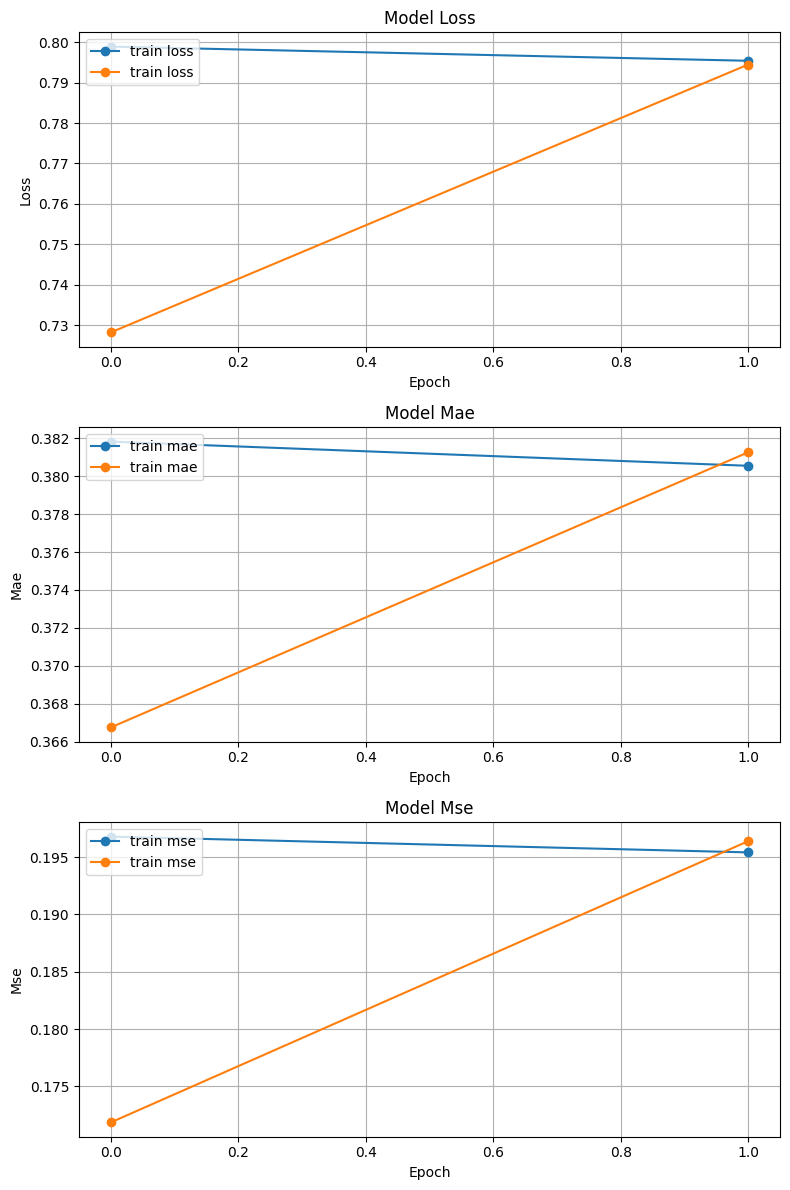

In [55]:
metrics = ["loss", "mae", "mse"]

#create subplots 
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"train {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [56]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [57]:
anime_weights = extract_weights("anime_embedding", model)

In [58]:
user_weights = extract_weights("user_embedding", model)

### Reading Anime.csv

In [59]:

df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)

In [60]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [61]:
df = df.replace("Unknown", np.nan)

In [62]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
        print("Error")

    return name

In [63]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [64]:
df["eng_version"]= df.anime_id.apply(lambda x:getAnimeName(x))

In [65]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [66]:
getAnimeName(6702)

'Fairy Tail'

In [67]:
df.sort_values(by =["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last"
               )

In [68]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [69]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [70]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [71]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [72]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [73]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [74]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


## Anime with Synopsis.csv

In [75]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [76]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols = cols)

In [77]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [78]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [79]:
getSynopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

## Content Based Recommendation System 

In [80]:
pd.set_option("max_colwidth", None)

In [106]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded,df, synopsis_df, n = 10, return_dist = False, neg=False):

    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f"Anime closest to {name}")


        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            #synopsis = getSynopsis(decoded_id, synopsis_df)

            anime_frame = getAnimeFrame(decoded_id, df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name": anime_name,
                "similarity" : similarity,
                "genre" : genre,
                #"synopsis" : synopsis

            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending = False)

        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)
        
    except Exception as e:
        print("Error Occurred ", e)

In [82]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
1,Area 88,0.310442,"Action, Military, Adventure, Drama, Romance","Shin Kazama, tricked and forced into flying for the remote country of Aslan, can only escape the hell of war by earning money for shooting down enemy planes or die trying. Through the course of the series, Shin must deal with the consequences of killing and friends dying around him as tries to keep his mind on freeing himself from this nightmare. (Source: ANN)"
0,Robokko Beeton,0.302968,"Adventure, Comedy, Kids, Slice of Life","hen a boy's uncle sends him confusing plans for a robot from America, the boy makes a mistake in the assembly which leads to unexpected results. (Source: AniDB)"


## Collaborative Filtering/ User Based recommendation 

In [83]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10 , return_dist=False, neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        
        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending = False) 
        
        similar_users = similar_users[similar_users.similar_users != item_input]

        return similar_users
    
    except Exception as e:
        print("Error Occured ",e)

In [84]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,7466,0.286630
8,11446,0.277717
7,14441,0.274390
6,7909,0.267356
5,13764,0.258166
4,9587,0.256499
3,11122,0.254555
2,8056,0.250936
1,7448,0.248206
0,7547,0.246789


In [85]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [86]:
from collections import defaultdict

In [87]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot: 
        showWordCloud(all_genres)
    
    return genres_list

In [88]:
x = getAnimeFrame(1,df)

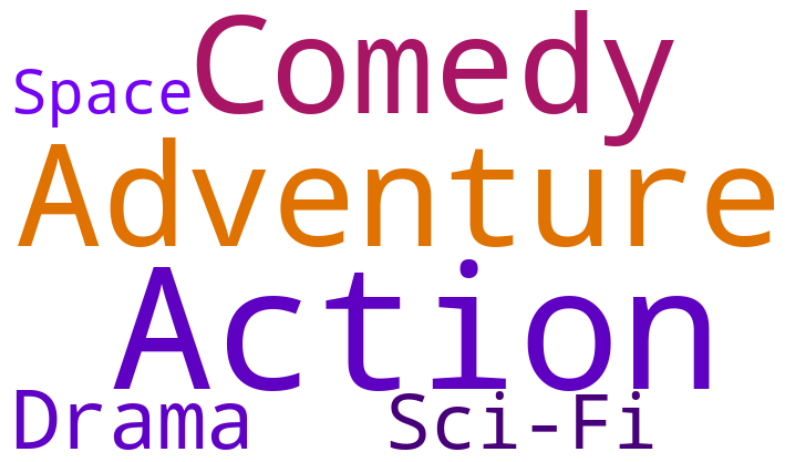

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [89]:
getFavGenre(x, plot=True)

In [90]:
def get_user_preferences(user_id, rating_df, df , verbose = 0, plot = False):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending = False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]

    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

In [91]:
get_user_preferences(11880, rating_df , df ,  plot = False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [92]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,7466,0.286630
8,11446,0.277717
7,14441,0.274390
6,7909,0.267356
5,13764,0.258166
4,9587,0.256499
3,11122,0.254555
2,8056,0.250936
1,7448,0.248206
0,7547,0.246789


In [98]:
def get_user_recommendations(similar_users, user_pref , df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df , df  )

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres": genre, 
                        "Synopsis" : synopsis
                    })  

    return pd.DataFrame(recommended_animes).head(n)



In [99]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)
user_pref = get_user_preferences(11880, rating_df , df ,  plot = False)

In [100]:
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)

,n,anime_name,Genres,Synopsis
0,9,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
1,9,Baka & Test - Summon the Beasts,"Comedy, Romance, School, Super Power","Fumizuki Academy isn't a typical Japanese high school. This unique institution has implemented a new and innovative system to sort its students. At the end of their freshman year, students take a test that divides up the student body. The highest scorers are placed into A class, all the way down until F class, for the lowest of the low. Unfortunately for Akihisa Yoshii, his supposedly ""great"" intellect wasn't quite enough for such a test, and he's now stuck at the bottom of F class. Naturally, F class has the worst facilities: not only rotten tatami mats and broken tables, but also outdated equipment and worn out furniture. On the bright side, his friend Yuuji Sakamoto is in the same class, and to everyone's surprise, the genius girl Mizuki Himeji has also ended up in the same class due to an unforeseen fever on the day of the test. Unsatisfied with their perquisites, F class rallies behind Yuuji, determined to take on the higher-tiered classes in order to seize their perks by using the school's Examinations Summon Battle system. The participants can summon fantasy characters—whose power levels are equal to their student's test scores—in an all-out battle. Will F class be able to rise to the top, or will they live up to everyone's expectations and fail?"
2,9,Toradora!,"Slice of Life, Comedy, Romance, School","uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process."
3,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for surviva

## Hybrid Recommender System

In [112]:
def hybrid_recommendation(user_id , user_weight=0.2, content_weight = 0.8):
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df , df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)

    user_recommended_anime_list  = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)
    ## Content Recommendation 

    content_recommended_animes = []

    for anime in user_recommended_anime_list: 
        similar_animes = find_similar_animes(
        anime,
        anime_weights,
        anime2anime_encoded,
        anime2anime_decoded,
        df,
        synopsis_df,
                )
        
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())

        else:
            print(f"No similar anime found {anime}")

    combined_Scores = {}

    for anime in user_recommended_anime_list:
        combined_Scores[anime] = combined_Scores.get(anime, 0) + user_weight 
    for anime in content_recommended_animes:
        combined_Scores[anime] = combined_Scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_Scores.items(), key=lambda x:x[1], reverse=True)

    return [anime for anime , score in sorted_animes[:10]]

In [114]:
hybrid_recommendation(15597)

['Naruto', 'The Girl Who Leapt Through Time', 'The Cat Returns', 'Naruto:Shippuden', 'Another', 'Bakuman.', 'Castle in the Sky', 'Darker than Black', 'Whisper of the Heart', 'Digimon:The Movie']
Anime closest to Naruto
Anime closest to The Girl Who Leapt Through Time
Anime closest to The Cat Returns
Anime closest to Naruto:Shippuden
Anime closest to Another
Anime closest to Bakuman.
Anime closest to Castle in the Sky
Anime closest to Darker than Black
Anime closest to Whisper of the Heart
Anime closest to Digimon:The Movie


['Toyama Tourism Anime Project',
 'Kaze no Shoujo Emily',
 'Vampiyan Kids Promotion',
 'Consultation Room',
 'Toilet no Hanako-san',
 'The Hakkenden:Legend of the Dog Warriors Part 2',
 'Special Duty Combat Unit Shinesman',
 'Bondage Game: Shinsou no Reijoutachi - Shinsou no Doreitachi',
 'Dusk Maiden of Amnesia:Ghost Girl',
 'Sekishoku Elegy']